In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score

from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [15]:

def mapSex(data):
    sex=pd.Series([i+1 for i in range(len(data.Sex.unique()))],data.Sex.unique())
    return data.Sex.map(sex)
#filling null value
def fillAge(data,value):
    data.Age=data.Age.fillna(value)
    data.Age=data.Age
    return data.Age.astype(int)

def Name(data):
    data.Name=data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    name=pd.Series([i+1 for i in range(len(data.Name.unique()))],data.Name.unique())
    return data.Name.map(name)

def fillEmbarkedAndMap(data,value):
    data.Embarked.fillna(value)
    embarked=pd.Series([i+1 for i in range(len(data.Embarked.unique()))],data.Embarked.unique())
    return data.Embarked.map(embarked)

In [16]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

print(train.info())

print('\n\nSummary Statistic of the Numeric columns: \n')
print(train.describe(include=['int64']))
print(train.describe(include=['float64']))
print('\n\nSummary Statistic of the character columns: \n')
print(train.describe(include=['object']))

print('\n\nSummary Statistic of the Null cell count for each column: \n')
print(train.isnull().sum().sort_values(ascending=False))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


Summary Statistic of the Numeric columns: 

       PassengerId    Survived      Pclass       SibSp       Parch
count   891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642    0.523008    0.381594
std     257.353842    0.486592    0.836071    1.102743    0.806057
min       1.000000    0.000000    1.000000    0.000000    0.000000
25%     223.500000    0.00000

In [17]:
train.Sex=mapSex(train)
test.Sex=mapSex(test)


fillnaAgeWith=train.Age.mean()

train.Age=fillAge(train,fillnaAgeWith)
test.Age=fillAge(test,fillnaAgeWith)

train.Name=Name(train)
test.Name=Name(test)


fillnaEmbarkedWith=train.Embarked.describe().top

train.Embarked=fillEmbarkedAndMap(train,fillnaEmbarkedWith)
test.Embarked=fillEmbarkedAndMap(test,fillnaEmbarkedWith)


train['Family']=train.Parch+train.SibSp
test['Family']=test.Parch+test.SibSp

train.Fare=train.Fare.fillna(train.Fare.mean())
test.Fare=test.Fare.fillna(train.Fare.mean())
#Mean normalization
train.Fare=(train.Fare-train.Fare.mean())/(train.Fare.max()-train.Fare.min())
test.Fare=(test.Fare-test.Fare.mean())/(test.Fare.max()-test.Fare.min())



In [18]:
train=train.drop(columns=['PassengerId','Ticket','Cabin' ])
train_X=train.drop(columns='Survived')
train_Y=train.Survived
rfc=RandomForestClassifier(n_estimators=100,n_jobs=-1).fit(train_X,train_Y)
print(pd.DataFrame({'feature':train_X.columns,'importance':rfc.feature_importances_}))


    feature  importance
0    Pclass    0.081377
1      Name    0.178179
2       Sex    0.152254
3       Age    0.214222
4     SibSp    0.031893
5     Parch    0.019479
6      Fare    0.237948
7  Embarked    0.028305
8    Family    0.056341


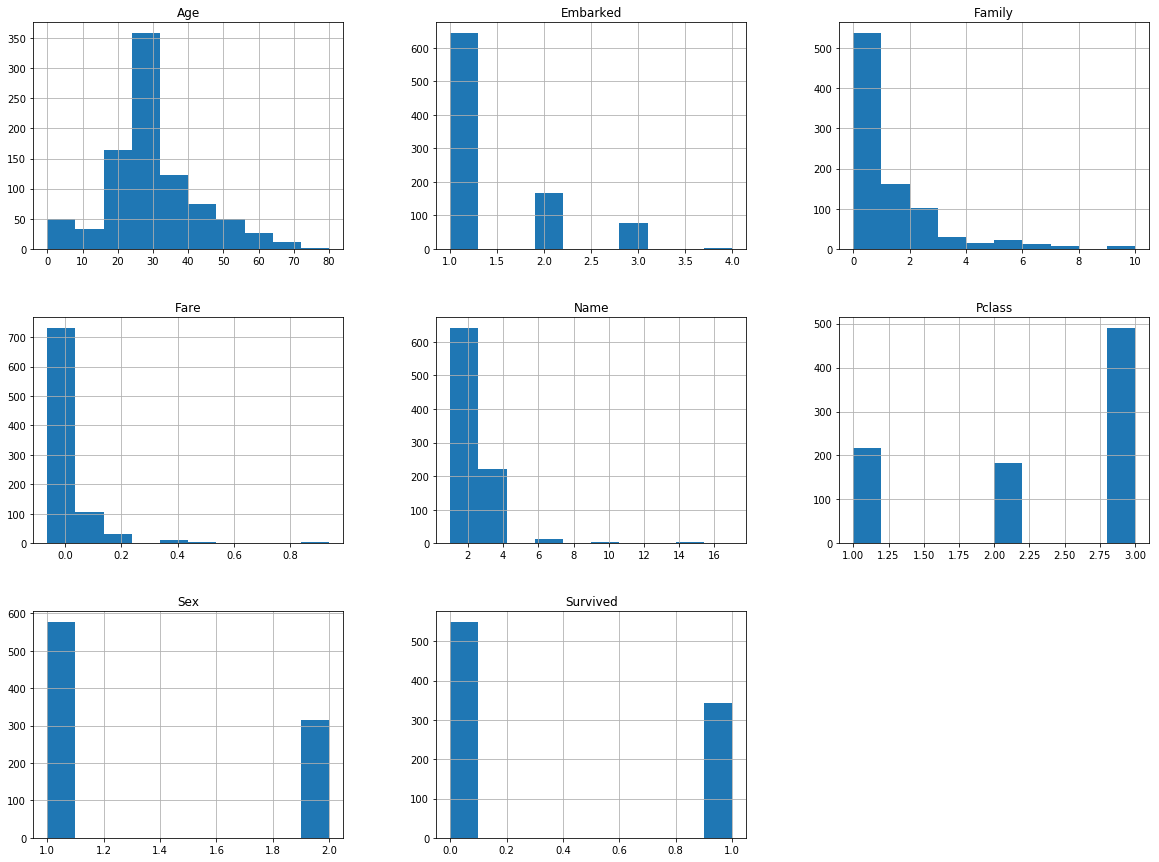

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family
Survived,1,-0.338481,0.29026,0.543351,-0.0678091,0.257307,0.118026,0.016639
Pclass,-0.338481,1,-0.191152,-0.1319,-0.335071,-0.5495,0.028566,0.0659969
Name,0.29026,-0.191152,1,0.361165,-0.0704073,0.108309,0.0894819,0.169749
Sex,0.543351,-0.1319,0.361165,1,-0.0825331,0.182333,0.128526,0.200988
Age,-0.0678091,-0.335071,-0.0704073,-0.0825331,1,0.0938558,0.016593,-0.24737
Fare,0.257307,-0.5495,0.108309,0.182333,0.0938558,1,0.0710096,0.217138
Embarked,0.118026,0.028566,0.0894819,0.128526,0.016593,0.0710096,1,-0.084639
Family,0.016639,0.0659969,0.169749,0.200988,-0.24737,0.217138,-0.084639,1


In [27]:
corrImg=train.corr().style.background_gradient(cmap='coolwarm')
train.hist(figsize=(20,15))
plt.savefig('hist.jpg')

plt.show()
corrImg

In [20]:
train=train.drop(columns=['SibSp','Parch'])
test=test.drop(columns=['SibSp','Parch',])
train_X=train.drop(columns='Survived')
train_Y=train.Survived
print(train_X.columns.values)

['Pclass' 'Name' 'Sex' 'Age' 'Fare' 'Embarked' 'Family']


In [21]:
param_GBC = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5],
    "n_estimators":[50],
    "random_state":[0]
}

param_RFC = {
    'criterion': ['gini','entropy'],
    'max_depth': [3, 5,],
    'max_features': [4,5,6,7],
    'n_estimators': [50],
    "random_state":[0]
}

param_ABC = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators":[50],
    "random_state":[0]
}

In [22]:
#3 different predications using different kernels and hyperparameters

linearSVM= SVC(kernel='linear',C=0.01)
rbfSVM=SVC(kernel='rbf',gamma='auto',C=0.1)
ploySVM =  SVC(kernel="poly",degree=3, gamma='scale',coef0=1, C=1)

#NB
NB=GaussianNB()

#Logistic regression
logreg = LogisticRegression(random_state=0, solver='lbfgs',max_iter=200,n_jobs=-1)

#3 different trees with different hyperparameters
DT1=DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=3 ,max_depth=5,random_state =0)
DT2=DecisionTreeClassifier(criterion='gini' ,max_leaf_nodes=2,max_depth=5,random_state =0 )
DT3=DecisionTreeClassifier(criterion='entropy' ,max_leaf_nodes=5,max_depth=5,random_state =0)
#Random Forest
RFC= GridSearchCV(RandomForestClassifier(),param_RFC,cv=5,n_jobs=-1,iid=False)
#Gradient Boosting Classifier
GBC = GridSearchCV(GradientBoostingClassifier(), param_GBC,cv=5, n_jobs=-1,iid=False)
#BaggingClassifier with Naïve bayes
BCNB=BaggingClassifier(GaussianNB(),n_estimators=10,bootstrap=True,n_jobs=-1,random_state=0)
#BaggingClassifier with decision trees)
BCDT=BaggingClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=10,bootstrap=True,n_jobs=-1,random_state=0)
#AdaBoosting (GridSearchCV for Hyperparameter Tuning)
ABC=GridSearchCV(AdaBoostClassifier(),param_ABC,cv=5,n_jobs=-1,iid=False)
#Voting-Ensembling
VC=VotingClassifier(estimators =[('psvm',ploySVM),('nb',NB),('lr',logreg),('bcdt',BCDT),('rfc',RFC)],voting ='hard',n_jobs=-1)

#KNNClassifier
KNN=KNeighborsClassifier(n_neighbors =7)
       

In [23]:
metrics=pd.DataFrame({'Model':[],'Accuracy':[],'Precision':[],'Recall':[],'F1_Score':[]},columns=['Model','Accuracy','Precision','Recall','F1_Score'])


In [24]:
skf = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
skf.get_n_splits(train_X,train_Y)

models=[linearSVM,rbfSVM,ploySVM,NB,logreg,DT1,DT2,DT3,RFC,GBC,BCNB,BCDT,ABC,VC,KNN]
modelsName=['linearSVM','rbfSVM','ploySVM','NB','logreg','DT1','DT2','DT3','RFC','GBC','BCNB','BCDT','ABC','VC','KNN']
count=0
for mode in models:
    Accuracy=0
    Precision=0
    Recall=0
    F1_Score=0
    print(mode)
    for train_index, test_index in skf.split(train_X, train_Y):    
        mode.fit(train_X.loc[train_index], train_Y[train_index])
        Y_pred = mode.predict(train_X.loc[test_index])
        Accuracy=Accuracy+accuracy_score(train_Y[test_index], Y_pred, normalize=True)
        Precision=Precision+precision_score(train_Y[test_index], Y_pred)
        Recall=Recall+recall_score(train_Y[test_index], Y_pred)
        F1_Score=F1_Score+f1_score(train_Y[test_index], Y_pred)

    Accuracy=Accuracy/5
    Precision=Precision/5
    Recall=Recall/5
    F1_Score=F1_Score/5
    metrics=metrics.append(pd.DataFrame({'Model':[modelsName[count]],'Accuracy':[Accuracy],'Precision':[Precision],'Recall':[Recall],'F1_Score':[F1_Score]}))
    count=count+1
print(metrics)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVC(C=1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
GaussianNB(priors=None, var_smoothing=1e-09)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
Decisio